# Data Prep

In [9]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime as dt

csv_data = pd.read_csv("Anime.csv")

csv_data.dropna(subset=['Score'], inplace=True)
csv_data.drop_duplicates()

newdf = pd.DataFrame(csv_data)
newdf["English"].fillna("Unknown", inplace=True)
for index, row in newdf.iterrows():
    # If the value in the "English" column is "Unknown"
    if row["English"] == "Unknown":
        # Fill in missing data from "Title" to "English"
        newdf.loc[index, "English"] = row["Title"]

newdf = csv_data
# 1.extract only the day of broadcast
newdf['Day'] = newdf['Broadcast'].apply(lambda x: x.split(' ')[0])
# 2. extract only the season of broadcast, ignore year
newdf['Season'] = newdf['Premiered'].apply(lambda x: x.split(' ')[0])
# 3. extract only the year of broadcast, ignore season, extract last 4 characters if value is not 'Unknown'
newdf["Start_Aired"] = pd.to_datetime(newdf["Start_Aired"], errors="coerce")
newdf["Year"] = newdf["Start_Aired"].dt.year

# 4. calculate total duration of each show
#Append Total Duration = Number of Episodes * Duration into the dataset.
results_list = []

for i, row in newdf.iterrows():
    result = (row['Episodes']) * row['Duration_Minutes']
    results_list.append(result)

newdf['Total duration'] = results_list

# 5. Calculate the ratio of Favourites vs Members for each show, round to 4dp
results_list = []

for i, row in newdf.iterrows():
    result = (row['Favorites']) / (row['Members'])
    #result = round(result, 4)
    results_list.append(result)

newdf['FMratio'] = results_list

# 6. remove anime with Status as not yet aired as they do not have a score
newdf = newdf[newdf["Status"].str.contains("Not yet aired") == False]
# 7. combine Themes and Genres to new column Themes_Genres
newdf["Themes_Genres"] = newdf["Themes"] + ", " + newdf["Genres"]
# 8. delete irrelevant columns
newdf = newdf.drop(["Premiered", "Broadcast", "Genres", "Themes", "Episodes", "Duration_Minutes", \
                    "Title", "ID","Japanese","Synonyms","Synopsis",\
                    "Start_Aired","End_Aired", "Ranked"], axis=1)

# 9. Delete anime with Year greater than 2022
mask = newdf['Year'] > 2022
newdf = newdf.drop(newdf[mask].index)

# Rank unknown
# newdf["Ranked"].fillna(value = 0, inplace = True)

# Year unknown
newdf["Year"].fillna(value = 0, inplace = True)

# Total duration unknown
newdf["Total duration"].fillna(value = 0, inplace = True)

English            object
Type               object
Status             object
Producers          object
Licensors          object
Studios            object
Source             object
Demographics       object
Rating             object
Score             float64
Scored_Users      float64
Popularity          int64
Members             int64
Favorites           int64
Day                object
Season             object
Year              float64
Total duration    float64
FMratio           float64
Themes_Genres      object
dtype: object

# EDA of Num Var

<AxesSubplot: >

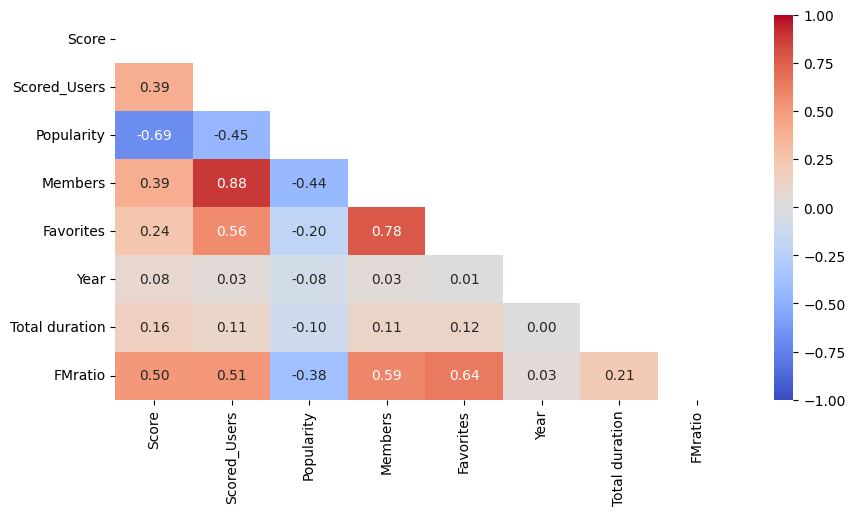

In [7]:
f = plt.figure(figsize=(10, 5))
corr = newdf.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = "coolwarm", mask = mask)

From this graph, we observe low correlation between Predictors `Year` and `Total duration` to Result `Score`. We continue to drop these variables as predictors.

In [8]:
newdf = newdf.drop(["Year", "Total duration"], axis=1)

# LinReg for Num Var

We will conduct 1 multi-variate regression model of all current predictors.

In [12]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Import the required function from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create a Linear Regression object
linreg = LinearRegression()

# Extract Response and Predictors
y = pd.DataFrame(newdf['Score'])
X = pd.DataFrame(newdf[list_predictors])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Train the Linear Regression model
linreg.fit(X_train, y_train)

# Predict SalePrice values corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

def plot_actual_vs_pred(y, y_pred, title=None):
    plot_df = pd.concat([pd.DataFrame(y, columns=['Score']), pd.DataFrame(y_pred, columns=['Score_pred'])], axis=1, join='inner')
    plot_df.sort_values(by=['Score'], inplace=True)
    plot_df.reset_index(inplace=True, drop=True)
    ax = sb.lineplot(data=plot_df)
    if title:
        ax.set_title(title)

def multiVariateModel (list_predictors):
    # Check the sample sizes
    print("Train Set :", X_train.shape, y_train.shape)
    print("Test Set  :", X_test.shape, y_test.shape)

    print('Intercept \t: b = ', linreg.intercept_)
    print('Coefficients \t: range(a) = ', linreg.coef_)

    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(y_train, y_train_pred, color = "blue")
    axes[0].plot(y_train, y_train, 'w-', linewidth = 5)
    axes[0].set_xlabel("True values of the Response Variable (Train)")
    axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
    axes[1].scatter(y_test, y_test_pred, color = "green")
    axes[1].plot(y_test, y_test, 'w-', linewidth = 5)
    axes[1].set_xlabel("True values of the Response Variable (Test)")
    axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
    plt.show()

    # Check the Goodness of Fit (on Train Data)
    print("Explained Variance (R^2) on Train Set \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) on Train Set \t:", mean_squared_error(y_train, y_train_pred))

    # Check the Goodness of Fit (on Test Data)
    print("Mean Squared Error (MSE) on Test Set \t:", mean_squared_error(y_test, y_test_pred))

Train Set : (10189, 3) (10189, 1)
Test Set  : (4367, 3) (4367, 1)
Intercept 	: b =  [7.15690933]
Coefficients 	: range(a) =  [[-1.17241592e-04  5.54870554e+01 -1.64455506e-07]]


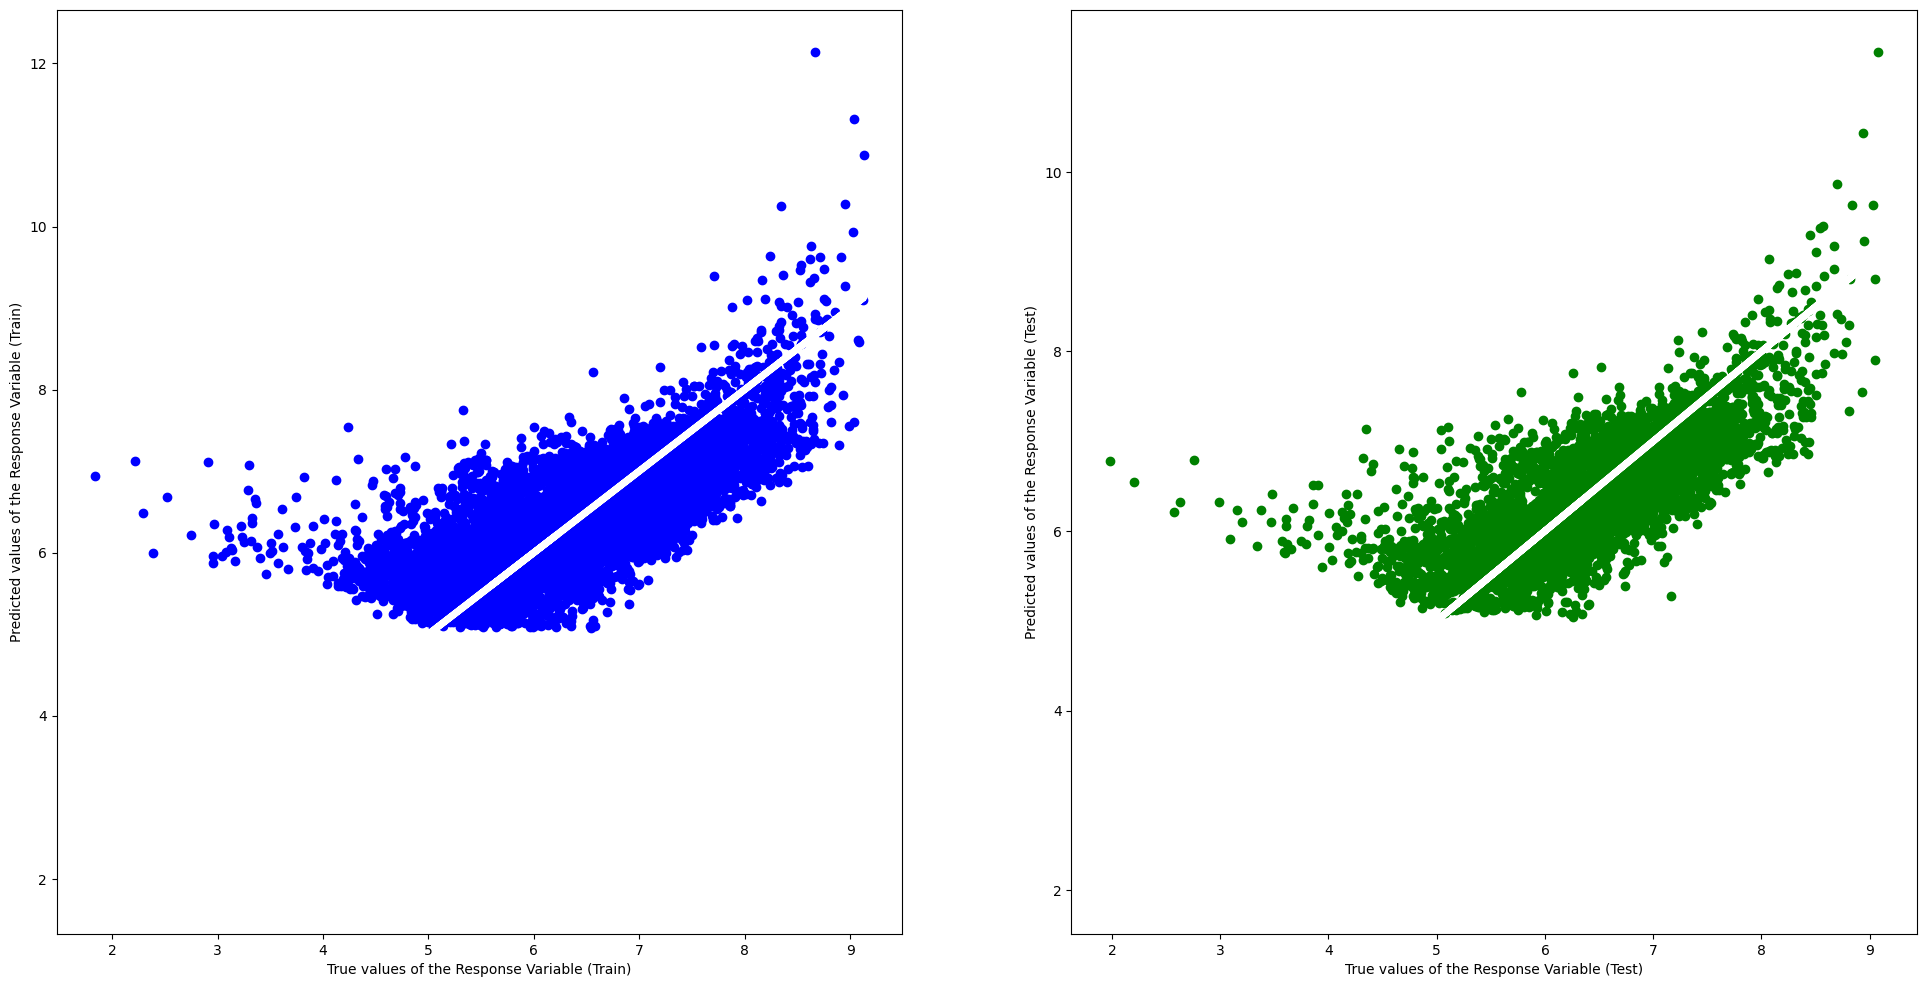

Explained Variance (R^2) on Train Set 	: 0.5370974496560378
Mean Squared Error (MSE) on Train Set 	: 0.3801615811271368
Mean Squared Error (MSE) on Test Set 	: 0.37947336856142344


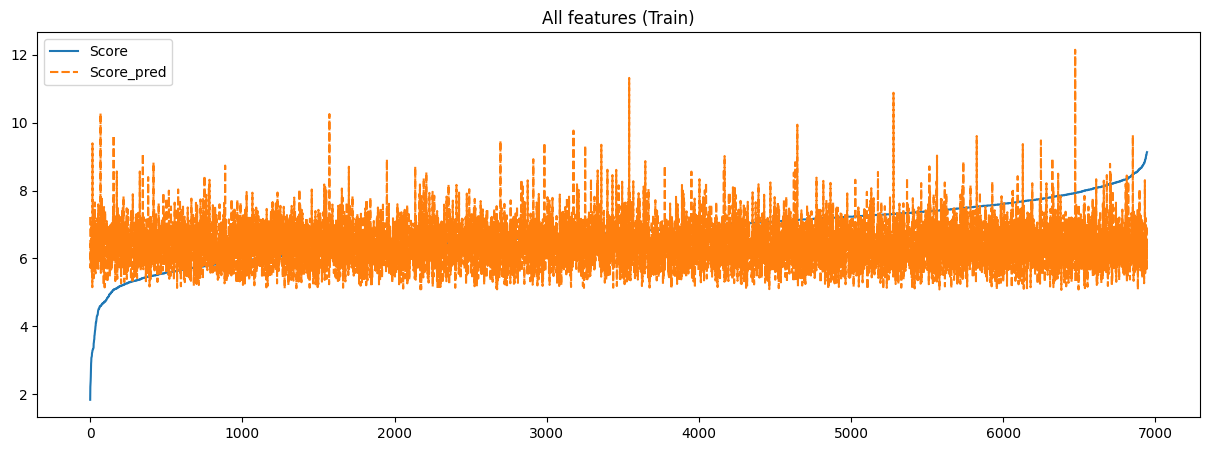

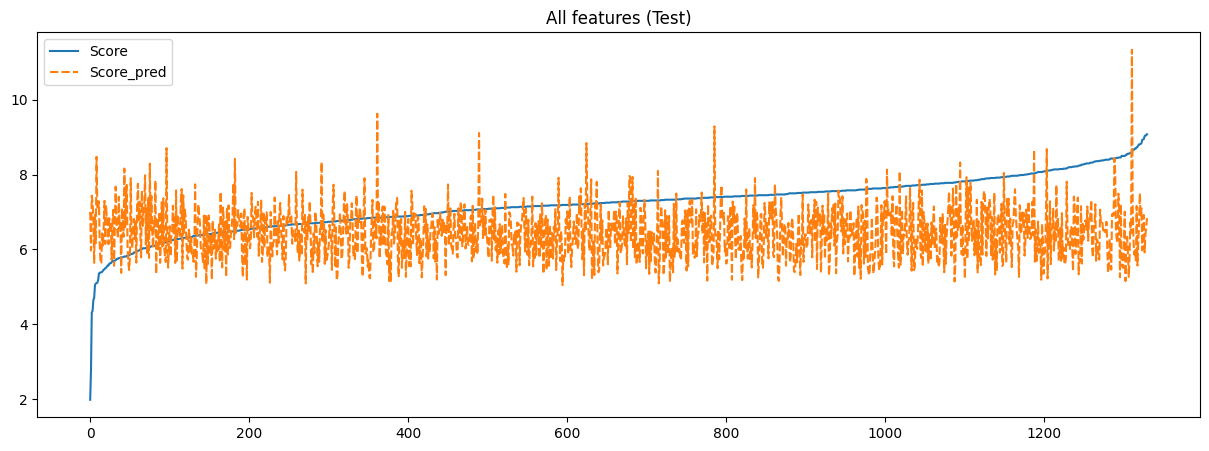

In [13]:
list_predictors = ['Popularity', 'FMratio', 'Scored_Users']
multiVariateModel(list_predictors)

fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train, y_train_pred, title='All features (Train)')

fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='All features (Test)')

- There is a tendency to over-predict for lower quartles of the dataset. 
- There is a good fit for train data but a much worse fit for test data, suggesting that this multivariate linear regression model is overfitting.

# Unsupervised Learning

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


KeyError: -1

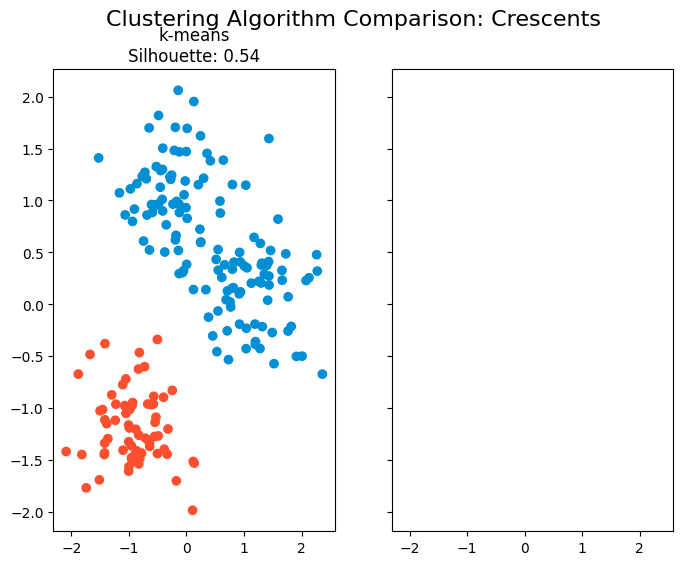

In [119]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
!pip install kneed
from kneed import KneeLocator

kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=300, random_state=42)
features, true_labels = make_blobs(n_samples=200,centers=3,cluster_std=2.75,random_state=42)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round (2)

# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=True)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = { 0: "#008fd5",1: "#fc4f30",}

# The k-means plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors)
ax1.set_title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})
# The dbscan plot
db_colors = [fte_colors[label] for label in dbscan.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=db_colors)
ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=11a139b8-46d6-4d29-a3ad-d2d21cc99056' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>